In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
true_df = pd.read_csv(r"C:\Users\pc\Downloads\News-_dataset\true.csv")
fake_df = pd.read_csv(r"C:\Users\pc\Downloads\News-_dataset\fake.csv")

print("True shape:", true_df.shape)
print("Fake shape:", fake_df.shape)


True shape: (21417, 4)
Fake shape: (23481, 4)


In [5]:
true_df['label'] = 1   # Real
fake_df['label'] = 0   # Fake

data = pd.concat([true_df, fake_df], axis=0)
data = data.sample(frac=1).reset_index(drop=True)

print(data.head())


                                               title  \
0   Planned Parenthood sues Indiana for abortion law   
1  U.S. Navy rolls out new measures after deadly ...   
2  Charlottesville schools, parents address child...   
3  SHOCKING VIDEO SHOWS HOW EASILY DRUG DEALERS S...   
4   What Trump Just Said The GOP Will Become If H...   

                                                text       subject  \
0  (Reuters) - Planned Parenthood of Indiana and ...  politicsNews   
1  PATTAYA, Thailand (Reuters) - The U.S. Navy ha...     worldnews   
2  CHARLOTTESVILLE, Va. (Reuters) - When white su...  politicsNews   
3  Feeling a little safer knowing how well our bo...      politics   
4  How does the saying go? If we don t learn from...          News   

                 date  label  
0      April 7, 2016       1  
1  November 20, 2017       1  
2    August 15, 2017       1  
3        Aug 22, 2015      0  
4        May 26, 2016      0  


In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


In [9]:
data['clean_text'] = data['text'].apply(clean_text)


In [10]:
X = data['clean_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (35918,)
Test size: (8980,)


In [15]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [13]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [16]:
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)

print("Sample Prediction:", y_pred[0])
print("Confidence Score:", max(y_prob[0]))


Sample Prediction: 1
Confidence Score: 0.9861776346087748


Accuracy: 0.9899777282850779

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4656
           1       0.99      0.99      0.99      4324

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



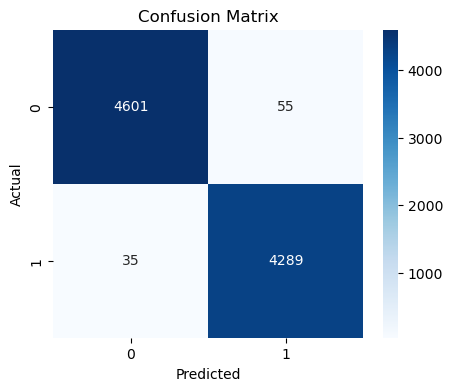

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

top_fake_words = sorted(zip(coefs, feature_names))[:15]

print("⚠️ Top Suspicious Words:")
for coef, word in top_fake_words:
    print(word)


⚠️ Top Suspicious Words:
via
image
obama
gop
america
mr
wire
even
hillary
american
like
rep
sen
daily
fox


In [19]:
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))


In [22]:
def predict_news(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0].max()

    if pred == 1:
        label = "Real News"
    else:
        label = "Fake News"

    print("Prediction:", label)
    print("Confidence:", prob)


In [21]:
predict_news("Breaking: Government secretly bans all bank withdrawals!")


Prediction: Fake News
Confidence: 0.8318856302743391
